###  Sparse GP Regression with FITC and predictive distribution- FITC prior for sampling over f.


This notebook uses the FITC prior to sample over the latent function values. The integration over inducing 
outputs(u) can be done analytically, and we can directly sample from the multivariate Gaussian. Data to be used will be Snelson 1D dataset.

In [12]:
%matplotlib inline
import  matplotlib
import matplotlib.pyplot as plt
import pystan

In [13]:
import numpy as np

In [14]:
import scipy.io as sio

In [15]:
df = sio.loadmat('snelson1d.mat')

In [16]:
X = df['X']
Y = df['Y']
X_t = df['tX']
Y_t = df['tY']

In [17]:
M = 20

In [18]:
SEED = 27042018

In [19]:
X_u_noisy = np.linspace(0,6, M)[:, None]
# X_u_noisy = X_u + 0.1*np.random.rand(*X_u.shape) 

### Code

In [20]:
stan_code_fitc_pred= """
functions{
    vector gp_pred_rng(real[] x_train, vector y, real[] xu, real[] x_star, real alpha, real rho, real sigma, real jitter){
        
        int N1 = rows(y);
        int N2 = size(x_star);
        int M = size(xu);
        matrix[N2, N2] cov_star;
        vector[M] K_div_y;
        vector[N2] f_star_mean;
        
        vector[N2] f_star;
        {
            vector[M] y_scaled;
            vector[M] L_S_div_y;
            matrix[N1,N1] diff;
            matrix[N1,N1] A;
            matrix[M, N1] v_pred;
            matrix[N1, M] S1;
            matrix[M, M] S;
            matrix[M, M] T;
            matrix[M, M] L_S;
            matrix[M, N2] v_pred_star;
            
            matrix[N1, N1] Kff = cov_exp_quad(x_train, alpha, rho);
            matrix[N1, M] Kfu = cov_exp_quad(x_train, xu, alpha, rho);
            matrix[N2, N2] K_star_star = cov_exp_quad(x_star, alpha, rho);
            matrix[M, M] Kuu = cov_exp_quad(xu, alpha, rho);
            
            // matrix[N1, N1] L_K= cholesky_decompose(Kff);
            matrix[M, M] L_U = cholesky_decompose(Kuu);
            matrix[N2, N1] K_star_f = cov_exp_quad(x_star, x_train, alpha, rho);
            matrix[N2, M] K_star_u = cov_exp_quad(x_star, xu, alpha, rho);
            matrix[M, N2]v_star = mdivide_left_tri_low(L_U, K_star_u');

            matrix[N2, N2] Q_star_star = v_star'*v_star;

            A= diag_matrix(rep_vector(0., N1));

            v_pred = mdivide_left_tri_low(L_U, Kfu');
            diff = Kff - v_pred'*v_pred;
            for (i in 1:N1){
                A[i,i] = 1./(diff[i,i]+square(sigma));
            }
            
            S1 = A*Kfu;
            S  = Kfu'*S1;
            
            T  = Kuu + S;
            L_S = cholesky_decompose(T);
            
            // matrix[M,M] S_inv = inverse(S);
            
            v_pred_star = mdivide_left_tri_low(L_S, K_star_u');
            cov_star = K_star_star - Q_star_star + v_pred_star'*v_pred_star;
            y_scaled = Kfu'*(A*y);

            L_S_div_y = mdivide_left_tri_low(L_S, y_scaled);    #forward substitution
            K_div_y = mdivide_right_tri_low(L_S_div_y', L_S)';   #backward substitiion
            f_star_mean = K_star_u*K_div_y;

            f_star = multi_normal_rng(f_star_mean, cov_star);

        }
        return f_star;

    }

}

data {
    int<lower=1> N;
    int<lower=1> M;
    int<lower=1> N_star;
    real x[N];
    real x_star[N_star];
    vector[N] y;
    real xu[M];
}

transformed data {
    real jitter = 1e-8;
#     real rho = 1;
#     real alpha = 1;

}
parameters {
    
    real<lower=1e-6> sigma;
    real <lower=1e-4> alpha;
    real<lower=1e-4> rho;
    vector[M] eta;
}

model {

    vector[N] f_mean;
    matrix[N, N] f_cov;
    matrix[N, N] A;
    matrix[N, N] diff;
        
    {
        matrix[M, M] L_U;
        matrix[M, M] Kuu = cov_exp_quad(xu, alpha, rho);
        matrix[N, M] Kfu = cov_exp_quad(x, xu, alpha, rho);
        matrix[N, N] K = cov_exp_quad(x, alpha, rho);
        vector[M] Kuu_inv_u;
        matrix[M, N] v_pred;
        vector[M] u;
        matrix[N,N] Qff;
        
        for (m in 1:M)
            Kuu[m, m] = Kuu[m, m] + jitter;
                    
        L_U = cholesky_decompose(Kuu);
        u = L_U * eta;
        
        // f_mean = Kfu*(Kuu_inv*u) = Kfu * inv(LL')u = Kfu * inv(L') *inv(L) * L * eta = = Kfu * inv(L') * eta;        
        Kuu_inv_u =  mdivide_left_tri_low(L_U, eta);
        f_mean = Kfu*Kuu_inv_u;
        

        // f_cov = K - Kfu*(Kuu_inv*Kfu');            
        v_pred = mdivide_left_tri_low(L_U, Kfu');
        Qff = v_pred'*v_pred;
        diff = K - Qff;
        for (i in 1:N){
            for(j in 1:N){
                A[i,j] = 0.0;
            }
            A[i,i] = diff[i,i] + square(sigma);
        }
        
        f_cov = A+Qff;
    }
    
    rho ~ normal(0.90, 0.50);
    alpha ~ normal(0.85, 0.50);

    sigma ~ normal(0, 0.60);
    eta ~ normal(0, 1);
    y ~ multi_normal(f_mean, f_cov);
}

generated quantities{
    vector[N_star] f_star = gp_pred_rng(x, y, xu, x_star, alpha, rho, sigma, jitter); 
    // vector[N_star] y_star = normal_rng(f_star, sigma);
    vector[N_star] y_star;
    for (i in 1:N_star){
        y_star[i] = normal_rng(f_star[i], sigma);
    }
    
}


"""


In [21]:
stan_model_fitc = pystan.StanModel(model_code=stan_code_fitc_pred)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_dace54e771925f548f7eac8ee93866ab NOW.


In [22]:
N_star = 25
X_star = np.linspace(-0.5, 6.5, N_star)[:, None]
M = 20

In [23]:
gp_fitc_pred_data = {'N':200, 'x':X.flatten(), 'y':Y.flatten(), 'M':M, 'xu':X_u_noisy.flatten(), 'N_star':N_star, 'x_star':X_star.flatten()}

In [24]:
SAMPLES_SIZE = 1000

In [25]:
fit_fitc = stan_model_fitc.sampling(data=gp_fitc_pred_data, iter=SAMPLES_SIZE, chains=2)

/u/26/dhakaa1/unix/anaconda2/envs/stanpy35/lib/python3.5/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [26]:
print(fit_fitc)

Inference for Stan model: anon_model_dace54e771925f548f7eac8ee93866ab.
2 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=1000.

             mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
f[0]       -3.8e7   3.5e7  5.0e7 -1.5e8 -9.2e7 -2.4e4 -1.0e4  -1814      2   2.49
f[1]        7.6e6   1.1e7  1.1e7 -8.1e6 5199.5 8732.3  1.5e7  3.3e7      1   1.84
f[2]        3.7e6   5.2e6  5.2e6 -6.2e5  -5594 1514.6  6.9e6  1.6e7      1   1.68
f[3]        1.2e7   1.3e7  1.3e7  -4914 -16.83  3.6e6  2.2e7  3.8e7      1   2.44
f[4]       -2.5e7   2.7e7  2.7e7 -6.7e7 -5.4e7 -8.6e6 2984.5  1.1e4      1   3.64
f[5]       -6.1e5   7.7e6  1.9e7 -3.6e7 -8.0e6  -1725 -609.1  4.7e7      6   1.65
f[6]       -6.7e6   6.3e6  8.9e6 -3.0e7 -1.2e7 -863.9  351.4 837.21      2   1.78
f[7]       -1.5e7   2.3e7  5.7e7 -1.7e8 1141.9  1.0e4  1.4e7  4.6e7      6   1.63
f[8]       -7.5e6   1.6e7  4.0e7 -1.2e8  -5951  -2766  1.2e7  4.1e7      6 

In [27]:
samples = fit_fitc.extract(permuted=True)
eta = samples['eta']
eta_mean = np.mean(eta, axis=0)
sigma = samples['sigma']
sigma_mean = np.mean(sigma, axis=0)
alpha = samples['alpha']
alpha_mean = np.mean(alpha, axis=0)
rho = samples['rho']
f_star = samples['f_star']
y_star = samples['y_star']
f_star_mean = np.mean(f_star, axis=0)
y_star_mean = np.mean(y_star, axis=0)

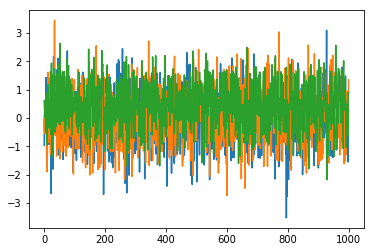

In [28]:
plt.plot(eta[:, 0])
plt.plot(eta[:, 1])
plt.plot(eta[:, 10])
plt.plot(eta[:, 10])

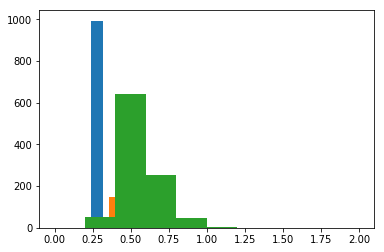

In [29]:

plt.hist(sigma, range=[0, 0.8]);
plt.hist(rho, range=[0.2, 1]);
plt.hist(alpha, range=[0, 2]);


#### Plots of one sample of f_star for 25 new test points.

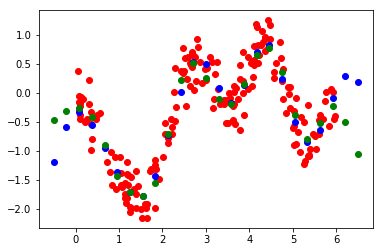

In [30]:
plt.plot(X,Y, 'ro')
plt.plot(X_star, f_star[4,:], 'bo')
plt.plot(X_star, f_star[720,:], 'go')

#### Plots of one sample of y_star for 25 new test points.

In [2]:
plt.plot(X,Y, 'ro')
plt.plot(X_star, y_star[4,:], 'bo')
plt.plot(X_star, y_star[720,:], 'go')

NameError: name 'plt' is not defined

In [ ]:
f_perc_25 = np.percentile(f, 2.5, axis=0)
f_perc_975 = np.percentile(f, 97.5, axis=0)

In [ ]:
plt.plot(X,Y, 'ro')
plt.plot(X, f_perc_25, 'bo')
plt.plot(X, f_perc_975, 'go')

In [32]:
f_star_perc_25 = np.percentile(f_star, 2.5, axis=0)
f_star_perc_975 = np.percentile(f_star, 97.5, axis=0)

In [33]:
y_star_perc_25 = np.percentile(y_star, 2.5, axis=0)
y_star_perc_975 = np.percentile(y_star, 97.5, axis=0)

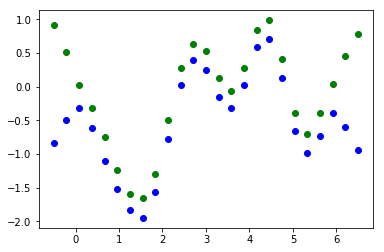

In [34]:
# plt.plot(X,Y, 'ro')
plt.plot(X_star, f_star_perc_25, 'bo')
plt.plot(X_star, f_star_perc_975, 'go')

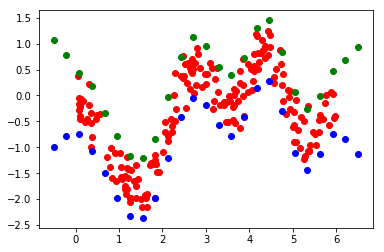

In [35]:
plt.plot(X,Y, 'ro')
plt.plot(X_star, y_star_perc_25, 'bo')
plt.plot(X_star, y_star_perc_975, 'go')

In [36]:
print("Mean difference for fstar between 2.5 and 97.5 percentile: %.3f"%np.mean(f_star_perc_975 - f_star_perc_25))
print("Mean difference for ystar between 2.5 and 97.5 percentile: %.3f"% np.mean(y_star_perc_975 - y_star_perc_25))

Mean difference for fstar between 2.5 and 97.5 percentile: 0.465
Mean difference for ystar between 2.5 and 97.5 percentile: 1.268


In [40]:
rand_inds = np.random.randint(SAMPLES_SIZE, size=5)

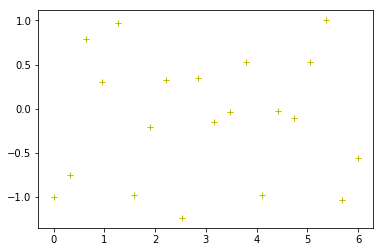

In [38]:
# plt.plot(X,Y, 'ro')
plt.plot(X_u_noisy, eta[-10,:], 'y+')
# plt.plot(X_u_noisy, eta[rand_inds[2],:], 'g+')

In [39]:
f_mean = samples['f_mean']

KeyError: 'f_mean'